<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/fem_peaks_counts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import packages

import multiprocessing
import cupy as cp
import numpy as np

from cupyx.scipy.special import erf
import matplotlib.pyplot as plt

import time
import gc
import os

In [2]:
# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()

        return gaussian_random_field

    def grf_64f_pk(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        ###k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()

        return gaussian_random_field


    def gaussian_to_exp(self, grf):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        grf = -1/self.lamb  * cp.log(1 - xu)

        return grf
#        return gaussian_random_field

In [3]:
# @title Paramters

num_gpu = 1 #number of GPU

pixel = 2**8
z_pixel = pixel
n_sigma = 0.5
# 30 7.5 sigma
# 25 7
# 20 6
# 13 5
k_power = 3
max_length = 10

main_folder = os.getcwd()


print(main_folder)


/content


In [4]:
# @title Run  Simulation

    # Initialize an instance of RFSIM
rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=k_power, lamb=1.0, n_sigma=n_sigma+1)
    # Generate a Gaussian random field
grf = rfsim.grf_64f()  # grf can be _32f or _64f
print(cp.std(grf), cp.mean(grf))
grf= cp.abs(grf)

grf_cp = cp.zeros_like(grf)
loc = cp.where(grf>n_sigma)
grf_cp[loc] = grf[loc]


cdx_grf = cp.diff(grf_cp, axis=0)
cdy_grf = cp.diff(grf_cp, axis=1)
cdz_grf = cp.diff(grf_cp, axis=2)


peaks_dx = cp.where(cp.diff(cp.sign(cdx_grf),axis=0)<0)
peaks_dy = cp.where(cp.diff(cp.sign(cdy_grf),axis=1)<0)
peaks_dz = cp.where(cp.diff(cp.sign(cdz_grf),axis=2)<0)


peaks_pos_x = cp.stack([peaks_dx[0] + 1, peaks_dx[1], peaks_dx[2]], axis=-1)
peaks_pos_y = cp.stack([peaks_dy[0], peaks_dy[1] + 1, peaks_dy[2]], axis=-1)
peaks_pos_z = cp.stack([peaks_dz[0], peaks_dz[1], peaks_dz[2] + 1], axis=-1)


peaks_set_x = set(map(tuple, cp.asnumpy(peaks_pos_x)))
peaks_set_y = set(map(tuple, cp.asnumpy(peaks_pos_y)))
peaks_set_z = set(map(tuple, cp.asnumpy(peaks_pos_z)))


0.51276688882809 1.4203048459560108e-17


In [5]:
peaks = peaks_set_y & peaks_set_x & peaks_set_z  # Use intersection for all three sets
print('Number of peaks found :', len(peaks))

del peaks_set_x, peaks_set_y, peaks_set_z

Number of peaks found : 976229


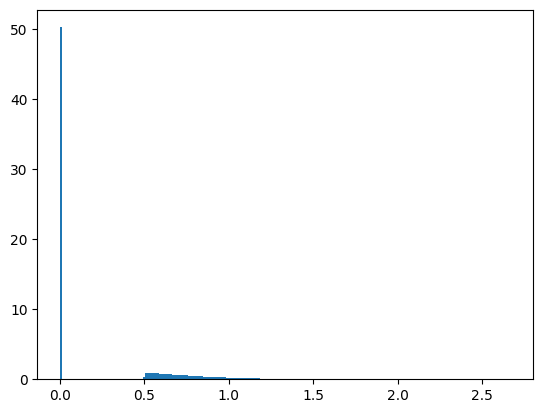

In [6]:
plt.hist( cp.asnumpy(grf_cp).flatten(),bins=201, density = True);

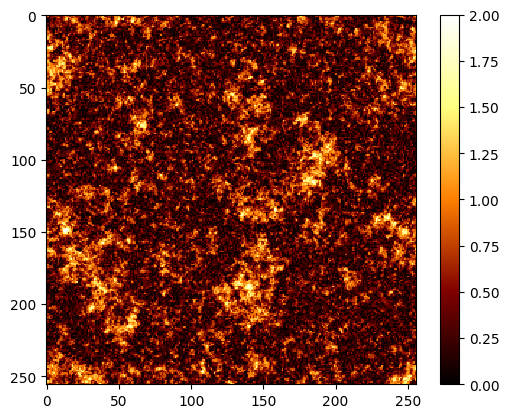

In [7]:
max_coor = cp.unravel_index(cp.argmax(grf_cp), grf_cp.shape)

plt.imshow( cp.asnumpy(grf[max_coor[0],:,:]), cmap='afmhot', vmin=0, vmax=2, interpolation='nearest')
plt.colorbar()
plt.show()

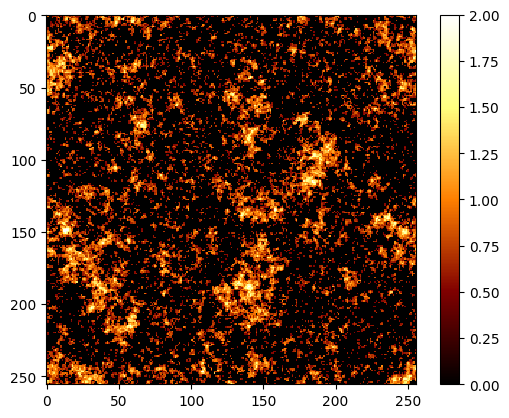

In [8]:
plt.imshow( cp.asnumpy(grf_cp[max_coor[0],:,:]), cmap='afmhot', vmin=0, vmax=2, interpolation='nearest')
plt.colorbar()
plt.show()

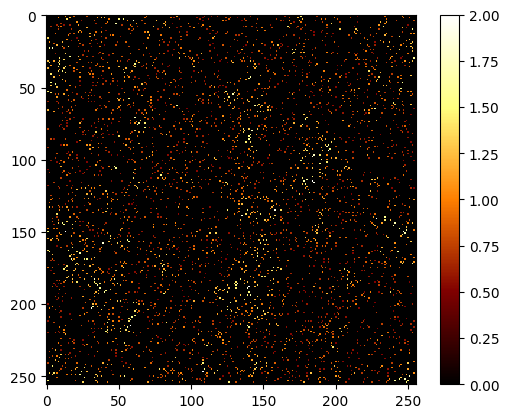

In [9]:
peaks_array = cp.array(list(peaks)).T
grf_peaks = cp.zeros_like(grf)
grf_peaks[peaks_array[0], peaks_array[1], peaks_array[2]] = grf[peaks_array[0], peaks_array[1], peaks_array[2]]

plt.imshow( cp.asnumpy(grf_peaks[max_coor[0],:,:]), cmap='afmhot', vmin=0, vmax=2, interpolation='nearest')
plt.colorbar()
plt.show()

(976229,)


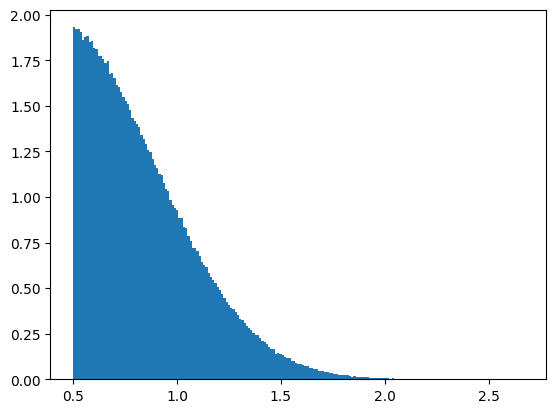

In [10]:
pt = grf_peaks[grf_peaks>0]
print(pt.shape)
plt.hist(cp.asnumpy(pt.flatten()), bins=201, density = True);